In [160]:
from pathlib import Path
import re

import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

sns.set_theme(style="whitegrid", font_scale=1, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [205]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]


def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))

    bars = []
    labels = []
    hue = []
    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path), cutoff=200).mean()
        *model, dist = label.split(" ")
        data.append({
            'reward': reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2.5,
        palette="Set2",
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(36, 107, 60), (220, 95, 46), (0, 122, 184)]
    for i, bar in enumerate(ax.patches):
        if i % n_models == 0 and len(baseline_rgb):
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb.pop(0)), orig[3]))

        elif i % n_models > 3:
            bar.set_hatch('..')

    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 200 episodes and 3 seeds in ManiSkill")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))

    bars = []
    labels = []
    hue = []
    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path), cutoff=50, min_length=21).mean()
        *model, dist = label.split(" ")
        data.append({
            'reward': reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2.5,
        palette="Set2",
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(36, 107, 60), (220, 95, 46), (0, 122, 184)]
    for i, bar in enumerate(ax.patches):
        if i % n_models == 0 and len(baseline_rgb):
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb.pop(0)), orig[3]))

        elif i % n_models > 3:
            if i == 5:
                bar.set_hatch('xxx')
            else:
                bar.set_hatch('..')

    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 50 episodes and 3 seeds in CARLA")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

[{'reward': 10.91115521316242, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 10.589080814711046, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 10.808499995227011, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 10.548903430586797, 'model': 'Baseline', 'Evaluation Distribution': 'OOD'}, {'reward': 10.616755346807185, 'model': 'Baseline', 'Evaluation Distribution': 'OOD'}, {'reward': 10.913860513672699, 'model': 'Baseline', 'Evaluation Distribution': 'OOD'}, {'reward': 0.10701059997718403, 'model': 'Baseline', 'Evaluation Distribution': 'Texture'}, {'reward': 0.14747184826872398, 'model': 'Baseline', 'Evaluation Distribution': 'Texture'}, {'reward': 0.1255285521348469, 'model': 'Baseline', 'Evaluation Distribution': 'Texture'}, {'reward': 10.886660591497861, 'model': 'DINO Finetune', 'Evaluation Distribution': 'ID'}, {'reward': 10.163853350208697, 'model': 'DINO Finetune', 'Evaluation Distribution': 'OOD'}, {'reward': 0.1514087084

<Figure size 6000x1800 with 0 Axes>

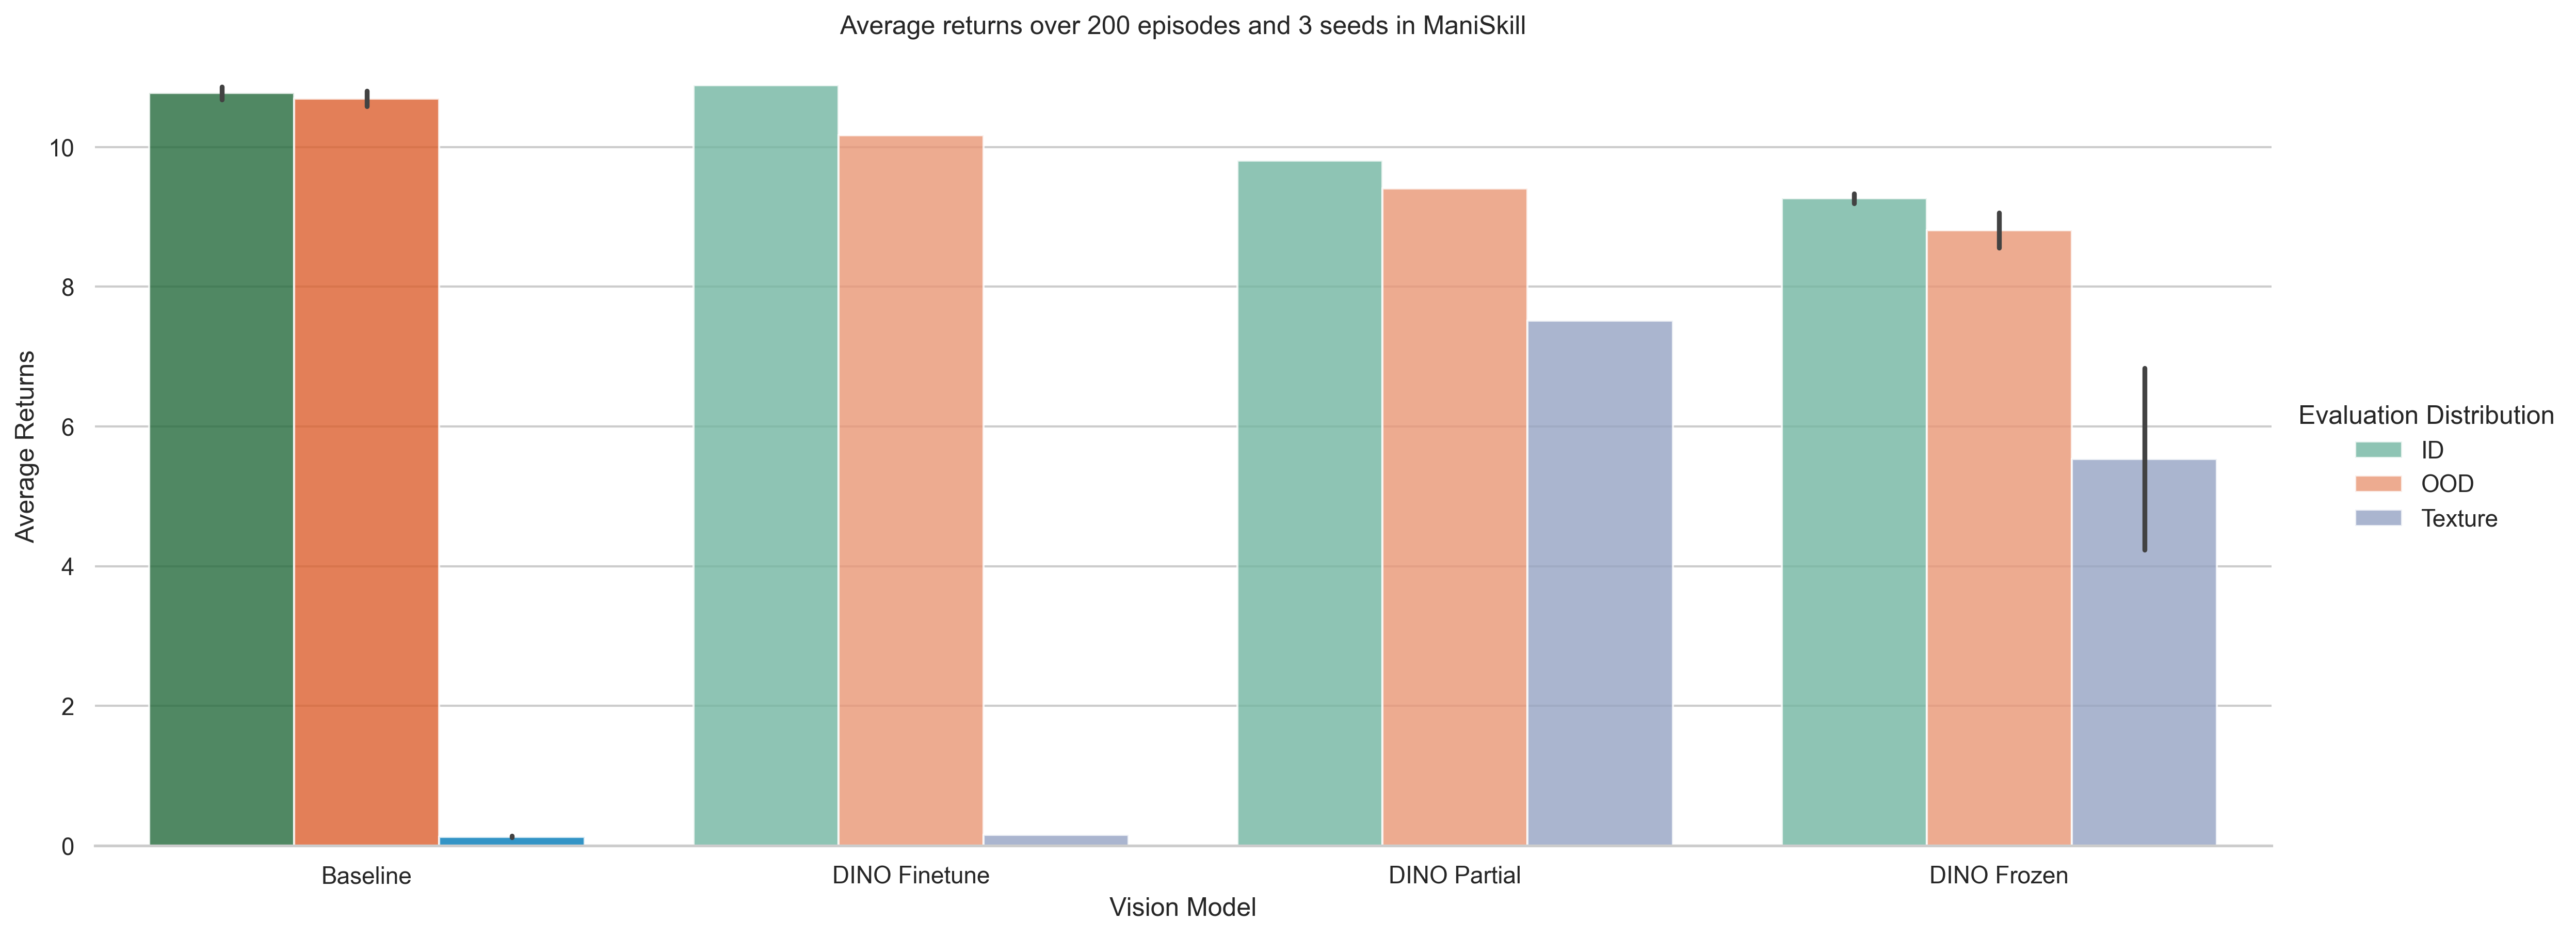

In [206]:
plot_maniskill(
    files_labels=[
        # ------- Baseline -------
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID/", "Baseline ID"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_1/", "Baseline ID"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_2/", "Baseline ID"),
        
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD/", "Baseline OOD"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_1/", "Baseline OOD"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_2/", "Baseline OOD"),

        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood/", "Baseline Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_1/", "Baseline Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_2/", "Baseline Texture"),

        # ------- DINO FT -------
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID/", "DINO Finetune ID"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD/", "DINO Finetune OOD"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood/", "DINO Finetune Texture"),

        # ------- DINO Partial -------
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID/", "DINO Partial ID"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD/", "DINO Partial OOD"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood/", "DINO Partial Texture"),

        # ------- DINO Frozen -------
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID/", "DINO Frozen ID"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_1/", "DINO Frozen ID"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_2/", "DINO Frozen ID"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD/", "DINO Frozen OOD"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_1/", "DINO Frozen OOD"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_2/", "DINO Frozen OOD"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood/", "DINO Frozen Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_1/", "DINO Frozen Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_2/", "DINO Frozen Texture"),
    ]
)

[{'reward': 377.29902971240693, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 410.9974950517714, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 299.884087347748, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 62.02624958534027, 'model': 'Baseline', 'Evaluation Distribution': 'Easy'}, {'reward': 41.71867405593395, 'model': 'Baseline', 'Evaluation Distribution': 'Easy'}, {'reward': 70.5092355363071, 'model': 'Baseline', 'Evaluation Distribution': 'Easy'}, {'reward': 38.336922818725, 'model': 'Baseline', 'Evaluation Distribution': 'Easy'}, {'reward': 21.271455326806755, 'model': 'Baseline', 'Evaluation Distribution': 'Easy'}, {'reward': 70.43066598370672, 'model': 'Baseline', 'Evaluation Distribution': 'Easy'}, {'reward': 18.422632095249572, 'model': 'Baseline', 'Evaluation Distribution': 'Hard'}, {'reward': 12.629755065776408, 'model': 'Baseline', 'Evaluation Distribution': 'Hard'}, {'reward': 16.018499172329904, 'model': 'Baselin

<Figure size 6000x1800 with 0 Axes>

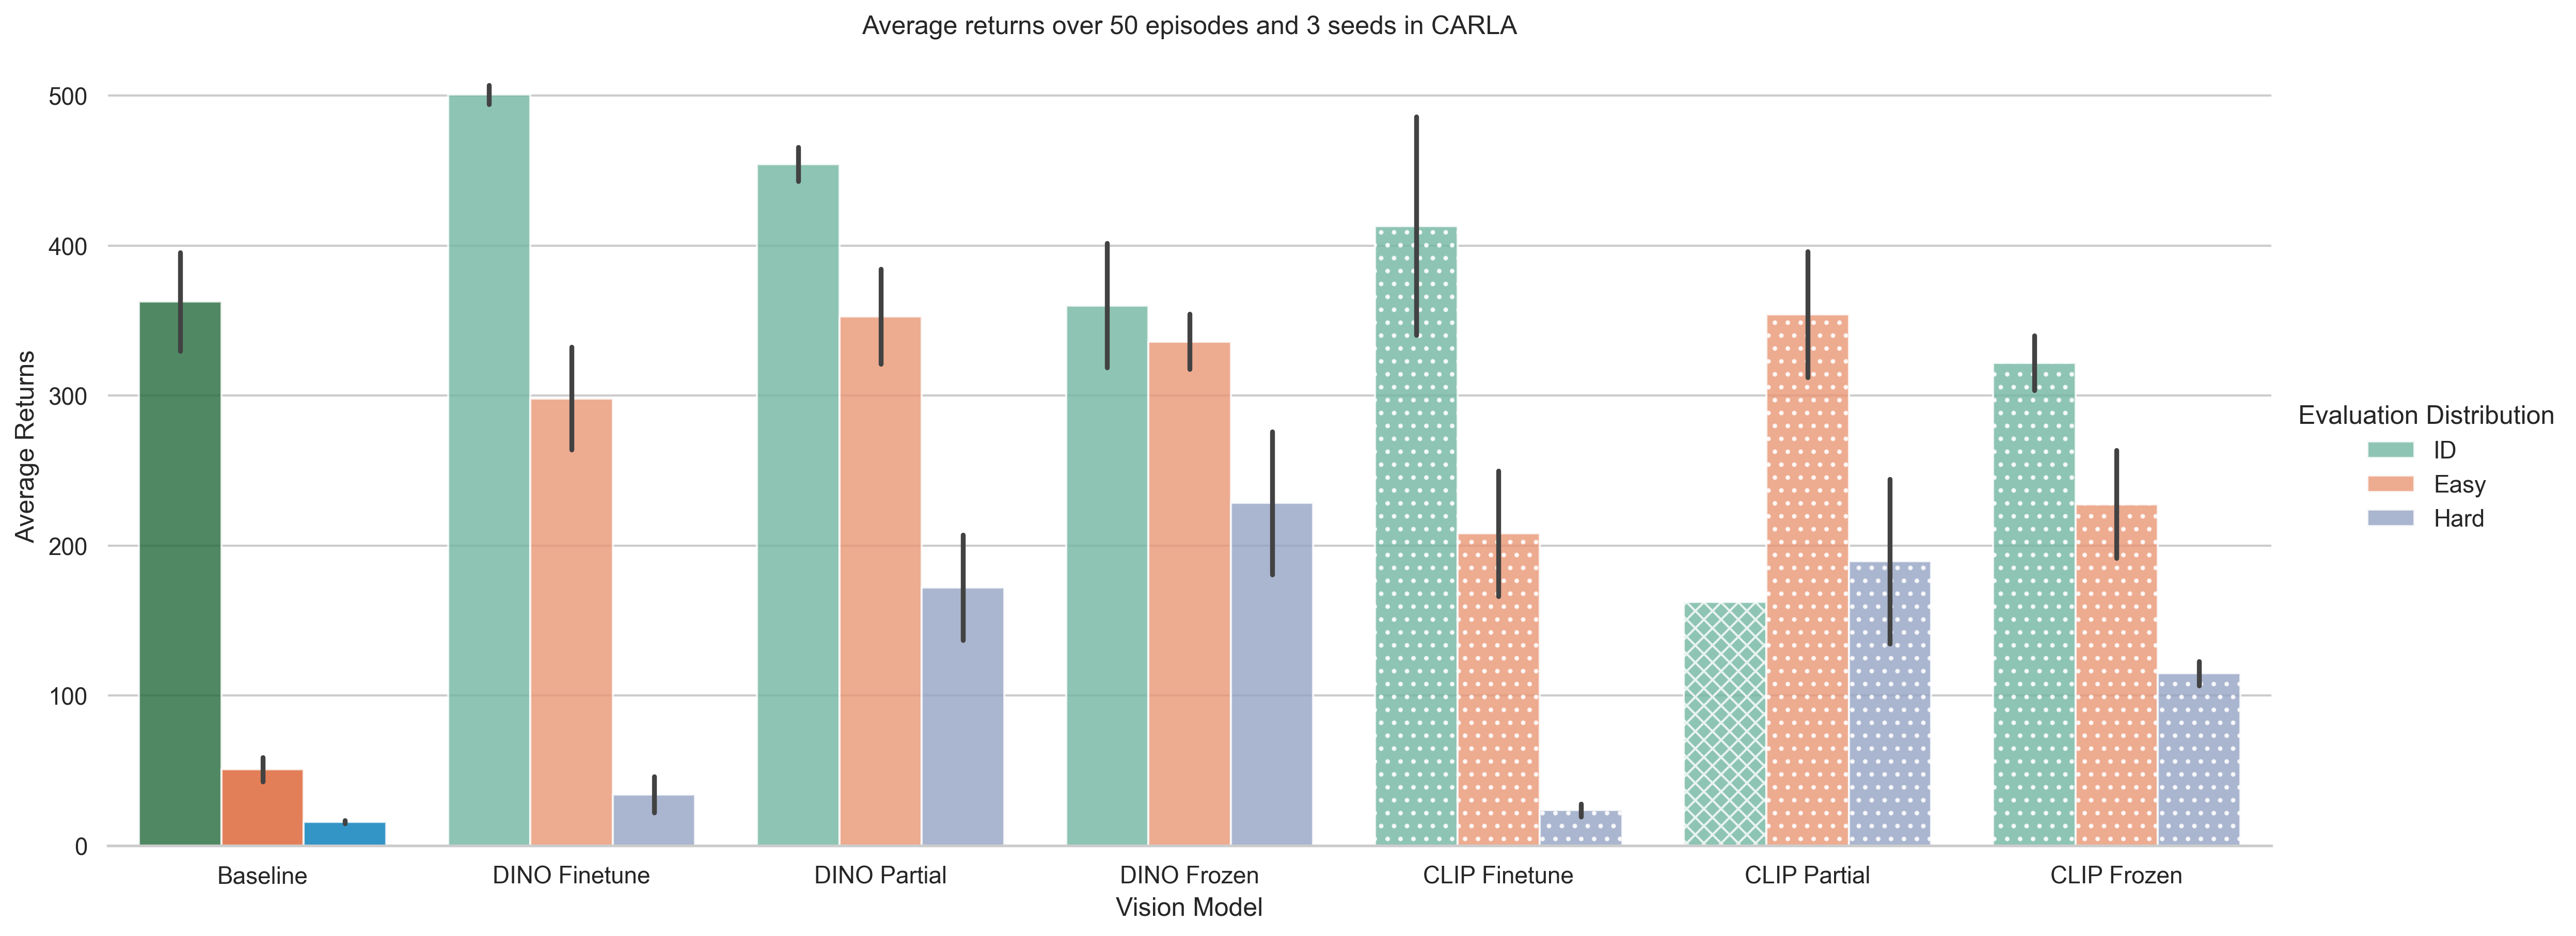

In [207]:
plot_carla(
    files_labels=[
        # ------- Baseline -------
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID", "Baseline ID"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_1", "Baseline ID"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_2", "Baseline ID"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light", "Baseline Easy"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_1", "Baseline Easy"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_2", "Baseline Easy"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light", "Baseline Easy"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_1", "Baseline Easy"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_2", "Baseline Easy"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light", "Baseline Hard"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_1", "Baseline Hard"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_2", "Baseline Hard"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light", "Baseline Hard"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_1", "Baseline Hard"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_2", "Baseline Hard"),

        # ------- DINO FT -------
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID", "DINO Finetune ID"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_1", "DINO Finetune ID"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_2", "DINO Finetune ID"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light", "DINO Finetune Easy"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_1", "DINO Finetune Easy"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_2", "DINO Finetune Easy"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light", "DINO Finetune Easy"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_1", "DINO Finetune Easy"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_2", "DINO Finetune Easy"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light", "DINO Finetune Hard"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_1", "DINO Finetune Hard"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_2", "DINO Finetune Hard"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light", "DINO Finetune Hard"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_1", "DINO Finetune Hard"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_2", "DINO Finetune Hard"),
        
        # ------- DINO Partial -------
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID", "DINO Partial ID"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_1", "DINO Partial ID"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_2", "DINO Partial ID"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light", "DINO Partial Easy"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_1", "DINO Partial Easy"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_2", "DINO Partial Easy"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light", "DINO Partial Easy"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_1", "DINO Partial Easy"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_2", "DINO Partial Easy"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light", "DINO Partial Hard"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_1", "DINO Partial Hard"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_2", "DINO Partial Hard"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light", "DINO Partial Hard"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_1", "DINO Partial Hard"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_2", "DINO Partial Hard"),

        # ------- DINO Frozen -------
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID", "DINO Frozen ID"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_1", "DINO Frozen ID"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_2", "DINO Frozen ID"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light", "DINO Frozen Easy"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINO Frozen Easy"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINO Frozen Easy"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light", "DINO Frozen Easy"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_1", "DINO Frozen Easy"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_2", "DINO Frozen Easy"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light", "DINO Frozen Hard"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINO Frozen Hard"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINO Frozen Hard"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light", "DINO Frozen Hard"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_1", "DINO Frozen Hard"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_2", "DINO Frozen Hard"),

        # ------- CLIP FT -------
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID", "CLIP Finetune ID"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_1", "CLIP Finetune ID"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_2", "CLIP Finetune ID"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light", "CLIP Finetune Easy"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_1", "CLIP Finetune Easy"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_2", "CLIP Finetune Easy"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light", "CLIP Finetune Easy"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_1", "CLIP Finetune Easy"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_2", "CLIP Finetune Easy"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light", "CLIP Finetune Hard"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_1", "CLIP Finetune Hard"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_2", "CLIP Finetune Hard"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light", "CLIP Finetune Hard"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_1", "CLIP Finetune Hard"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_2", "CLIP Finetune Hard"),

        # ------- CLIP Partial -------
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP Partial ID"),
        # ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID", "CLIP Partial ID"),
        # ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_1", "CLIP Partial ID"),
        # ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_2", "CLIP Partial ID"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP Partial Easy"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_1", "CLIP Partial Easy"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_2", "CLIP Partial Easy"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light", "CLIP Partial Easy"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_1", "CLIP Partial Easy"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_2", "CLIP Partial Easy"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light", "CLIP Partial Hard"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_1", "CLIP Partial Hard"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_2", "CLIP Partial Hard"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light", "CLIP Partial Hard"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_1", "CLIP Partial Hard"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_2", "CLIP Partial Hard"),

        # ------- CLIP Frozen -------
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID", "CLIP Frozen ID"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_1", "CLIP Frozen ID"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_2", "CLIP Frozen ID"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light", "CLIP Frozen Easy"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_1", "CLIP Frozen Easy"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_2", "CLIP Frozen Easy"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light", "CLIP Frozen Easy"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_1", "CLIP Frozen Easy"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_2", "CLIP Frozen Easy"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light", "CLIP Frozen Hard"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_1", "CLIP Frozen Hard"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_2", "CLIP Frozen Hard"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light", "CLIP Frozen Hard"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_1", "CLIP Frozen Hard"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_2", "CLIP Frozen Hard"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_3562/1506220593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Catastrophic Forgetting: ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='Test Accuracy (%)'>

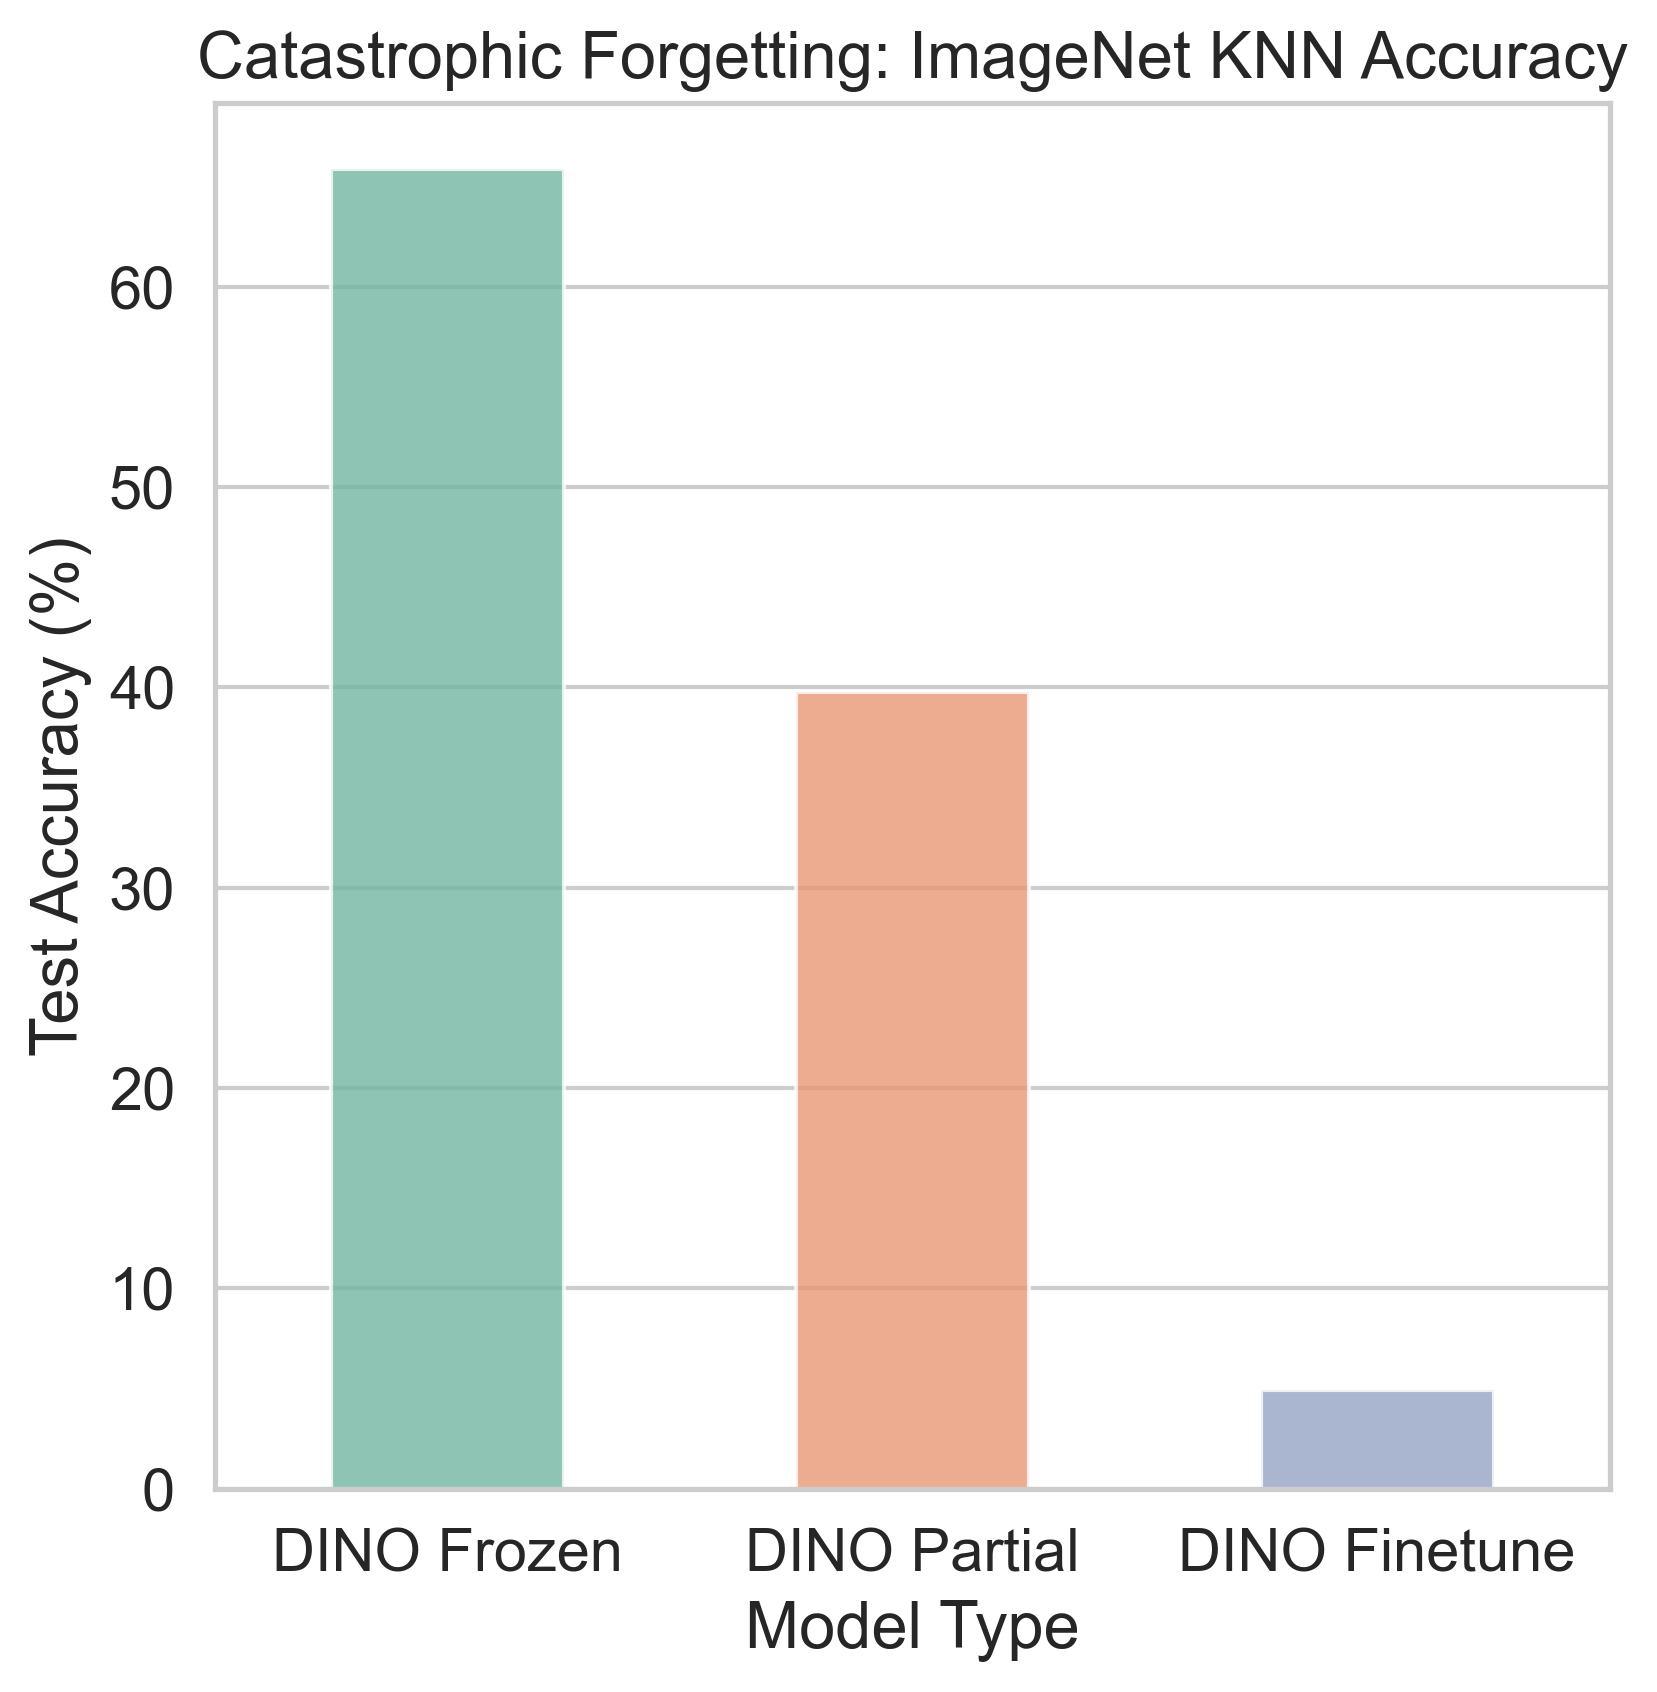

In [13]:
imagenet_knn_accuracy = [65.88, 39.77, 4.92]
imagenet_knn_labels = ["DINO Frozen", "DINO Partial", "DINO Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Catastrophic Forgetting: ImageNet KNN Accuracy")
sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)